<a href="https://colab.research.google.com/github/knoriy/depth_estimation/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Activation, BatchNormalization, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, Dropout

In [0]:
import os
import time
import tqdm
import shutil
import imageio
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display


## Globals

In [0]:
style_weight            = 1e-1  # Weight, Controling the contribution of the style image
content_weight          = 0.01   # Weight, Controling the contribution of the content image
total_variation_weight  = 1e4   # Weight, controling the total change across the image (removing noise)

epochs                  = 1000

## Utility functions

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
def tensor_to_image( tensor ):
  '''
  This function converts a tensor to a numpy array that can be read by PIL 

  Arguments:
    tensor - A tensorflow tensor

  Returns:
    A PIL image
  '''
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
def get_time(): 
  '''
  This function gets the current date and time (d-m-y-h-m-s)

  Return:
    String, Containing the day, month, year, hour, minute, seconds
  '''
  return time.strftime("%d-%m-%y_%H-%M-%S")

In [0]:
def remove_files(*directories):
  '''
  This functions deletes files or directories passed in.

  Arguments:
    *directory - String, The directory or file to be removed. This is a *args argument, any number or 
                 arguments can be passed and the delete operation will be performed of what is passed
  '''
  for directory in directories:
    if not os.path.exists(directory):
      raise ValueError("{} could not be found, please check it exists".format(file_name))

  for directory in tqdm.tqdm(directories):
    if os.path.isdir(directory):
      shutil.rmtree(directory)
    elif os.path.isfile(directory):
      os.remove(directory)
    else:
      raise OSError("UNKOWN ERROR: Could not delete {}".format(directory))

In [0]:
def create_video(save_dir, source_dir, mode="?"):
  '''
  This function created a video from a given list of images

  Arguments:
    save_dir    - Takes in as string, The directory to save the video
    source_dir  - Takes in as string, The directory to the images to be convereted to video
    mode        - Used to give the writer a hint on what the user expects (default ‘?’): “i” for an image, 
                  “I” for multiple images, “v” for a volume, “V” for multiple volumes, “?” for don’t care.
  
  '''
  # creating a abs list of images directories in a given dirctory
  source_images = [os.path.join(source_dir, file) for file in os.listdir(source_dir)]

  with imageio.get_writer(save_dir, mode=mode) as writer:
    for source_image in tqdm.tqdm(source_images):
      image = imageio.imread(source_image)
      writer.append_data(image)

### Load data

In [0]:
def load_img( path_to_image ):
  '''
    This function loads a given image and normalized this into [0,1] range

    Arguments:
      path_to_img - expects string to the file

    Returns:
      A converted tenor with a range of [0,1]

  '''
  img = tf.io.read_file(path_to_image)                # load the raw data from the file as a string
  img = tf.image.decode_image(img, channels=3)        # convert the compressed string to a 3D uint8 tensor
  img = tf.image.convert_image_dtype(img, tf.float32) # convert image from 0-255 to floats in the [0,1] range.

  # img = img[tf.newaxis, :]

  return img

In [0]:
##############################################
# Resizing image, is broken, due to me adding "img = img[tf.newaxis, :]" into load_image
def image_resize( image, max_dim ):
  '''
    Resizes an given image

    Arguments:
      image     - The image to be resized
      max_dim - The maximum dimension in a given axis

    Returns:
     A resized image in tensor
    
  '''

  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

def image_resize_with_crop_or_pad( image, target_height, target_width):
  image = tf.image.resize_with_crop_or_pad(image, target_height, target_width) 
  image = image[tf.newaxis, :]
  return image

In [0]:
def imshow(image, title=None):
  '''
    Display a given image on screen

    Arguments:
      image - The image to be displayed
      title - expects string, the tile to be displayed above the image

  '''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [0]:
def getImageList(dir):
  '''
  This fuction gets a list of all files in a given directory
  
  Arguments:
    dir - The directory to the files
  
  Returns: 
    A list of files

  '''
  contents = os.listdir(dir)

  dir_list = []
  for content in contents:
    dir_list.append(os.path.join(dir, content))

  return dir_list

def getImageSequence(images):
  '''
  This function creates a sequence of decoded images in [0,1] space.

  Arguments:
    images - Expects a list of directories.

  Returns:
    A list of converted tenors with a range of [0,1].
    
  '''

  tf_images = []
  for image in images:
    tf_images.append(load_img(image))
  return tf_images

# MODEL


## AutoEncoder


In [0]:
def identity_block(x, filters, kernel_size, stride, padding='same'):
  '''
    Implementation of the identity block as shown in the ResNet paper:
      https://arxiv.org/abs/1512.03385
    
    Arguments:
      x           - Input tensor of the previous layers 
      filters     - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
      kernel_size - An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
                    Can be a single integer to specify the same value for all spatial dimensions.
      stride      - An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and 
                    width. Can be a single integer to specify the same value for all spatial dimensions.
      padding     - one of "valid" or "same" (case-insensitive).

    Returns:
      The identity matrix
  '''
  x_shortcut = x

  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(rate=2e-1)(x)

  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(rate=2e-1)(x)

  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding )(x)
  x = BatchNormalization()(x)
  x = Dropout(rate=2e-1)(x)

  x = Add()([x, x_shortcut])
  x = Activation('relu')(x)

  return x

In [0]:
def conv_block(x, filters, kernel_size, stride, padding='same'):
  '''
    Creating a block of convolutinal layers with BatchNormalization and an activation of relu
    
    Arguments:
      x           - Input tensor
      filters     - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
      kernel_size - An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
                    Can be a single integer to specify the same value for all spatial dimensions.
      stride      - An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and 
                    width. Can be a single integer to specify the same value for all spatial dimensions.
      padding     - one of "valid" or "same" (case-insensitive).

    Returns:
      The identity matrix
  '''
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = Dropout(rate=2e-1)(x)
  x = AveragePooling2D(pool_size=(2,2), strides=1, padding=padding)(x)

  return x

In [0]:
def deconv_block(x, filters, kernel_size, stride, padding='same'):
  '''
  Creating a block of deconvolutinal layers with BatchNormalization and an activation of relu
  
  Arguments:
    x           - Input tensor
    filters     - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    kernel_size - An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
                  Can be a single integer to specify the same value for all spatial dimensions.
    stride      - An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and 
                  width. Can be a single integer to specify the same value for all spatial dimensions.
    padding     - one of "valid" or "same" (case-insensitive).

  Returns:
    The identity matrix
  '''
  x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = Dropout(rate=2e-1)(x)

  # x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=stride, padding=padding)(x)
  # x = BatchNormalization(axis = 3)(x)
  # x = Activation('relu')(x)
  # x = Dropout(rate=2e-1)(x)
  
  return x

In [0]:
def create_model(input_shape=(512,512,3)):
  '''
    Creating the autoencoder as describes in the ReCoNet Paper:
      https://arxiv.org/abs/1807.01197
      
    Arguments:
      input_shape - tuple of integers, representing width, height and channels
    
    Returns:
      model - an autoencoder arcutecture with 4 residual blocks
  '''
  x_input = Input(input_shape)

  #####################################################################
  # Encoder
  #####################################################################
  x = conv_block(x=x_input, filters=64 , kernel_size=2, stride=1, padding='same') 
  x = conv_block(x=x, filters=128, kernel_size=2, stride=2, padding='same')
  x = conv_block(x=x, filters=256, kernel_size=2, stride=2, padding='same')
  #####################################################################
  # Encoder
  #####################################################################



  #####################################################################
  # Residual Block
  #####################################################################
  x = identity_block(x=x, filters=256, stride=1, kernel_size=2)
  x = identity_block(x=x, filters=256, stride=1, kernel_size=2)
  x = identity_block(x=x, filters=256, stride=1, kernel_size=2)
  x = identity_block(x=x, filters=256, stride=1, kernel_size=2)
  #####################################################################
  # Residual Block
  #####################################################################



  #####################################################################
  # Encoder
  #####################################################################
  x = deconv_block(x=x, filters=256, kernel_size=2, stride=2, padding='same')
  x = deconv_block(x=x, filters=128, kernel_size=2, stride=2, padding='same')
  x = deconv_block(x=x, filters=64 , kernel_size=2, stride=1, padding='same')
  #####################################################################
  # Encoder
  #####################################################################


  x = Conv2DTranspose(filters=3, kernel_size=2, strides=1, padding='same')(x)
  x = Activation('tanh')(x)

  model = tf.keras.Model(inputs = x_input, outputs = x, name='myModel')
  return model

In [0]:
model = create_model((512, 512, 3))
tf.keras.utils.plot_model( model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TD', expand_nested=False, dpi=60 );

## VGG

In [0]:
content_layers = ['block4_conv2']   # Content VGG Layers
style_layers   = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']   # Style VGG Layers

### VGG Feature Extractor


In [0]:
class VGG_FeatureExtractor(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg =  self.get_vgg_layers(style_layers + content_layers)

    self.style_layers = style_layers
    self.content_layers = content_layers

    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)

  def call(self, inputs):

    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # pre processing the image using the VGG network
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs_gram = []
    for style_output in style_outputs:
      style_outputs_gram.append( self.gram_matrix(style_output) )

    content_dict = {}
    for content_name, value in zip ( self.content_layers, content_outputs ):
      content_dict.update({content_name:value})

    style_dict = {}
    for style_name, value in zip( self.style_layers, style_outputs_gram ):
      style_dict.update({style_name:value})
    
    return {'content':content_dict, 'style':style_dict}
  
  def get_vgg_layers(self, layer_names):

    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model
    
  def gram_matrix(self, input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

  
  def get_vgg_layers(self, layer_names):

    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model
    
  def gram_matrix(self, input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Style Content loss


In [0]:
def style_content_loss(style_outputs, style_targets , content_outputs, content_targets):
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / len(style_layers)

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / len(content_layers)
  
  loss = style_loss + content_loss
  return loss

## Prerequisite

### Download content and style images

In [0]:
CONTENT_PATH  = tf.keras.utils.get_file('street.jpg',       'https://i.pinimg.com/originals/e3/f5/29/e3f529e7b972fc693f9a73b11401399a.jpg')
STYLE_PATH    = tf.keras.utils.get_file('oilPainting_2.jpg','https://images-na.ssl-images-amazon.com/images/I/917exGYqGmL._SL1500_.jpg')

### Image preprocessing

In [0]:
# coverting images to tensorflow readable tensors
content_image = load_img(CONTENT_PATH)
style_image   = load_img(STYLE_PATH)

content_image = image_resize_with_crop_or_pad(content_image, 512, 512)
style_image   = image_resize_with_crop_or_pad(style_image, 512, 512)

# content_image = image_resize(content_image, 512)
# style_image   = image_resize(style_image, 512)

### Style and content extraction

In [0]:
# Instantiating VGG feature extractor
feature_extractor = VGG_FeatureExtractor(style_layers, content_layers)

In [0]:
content_targets = feature_extractor(content_image)["content"]
style_targets   = feature_extractor(style_image)["style"]

### Metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")

### Callbacks

# Train

In [0]:
opt    = tf.optimizers.Adam(learning_rate=1e-2, beta_1=0.99, epsilon=1e-1)
image  = tf.Variable(content_image)
output = tf.Variable(content_image)

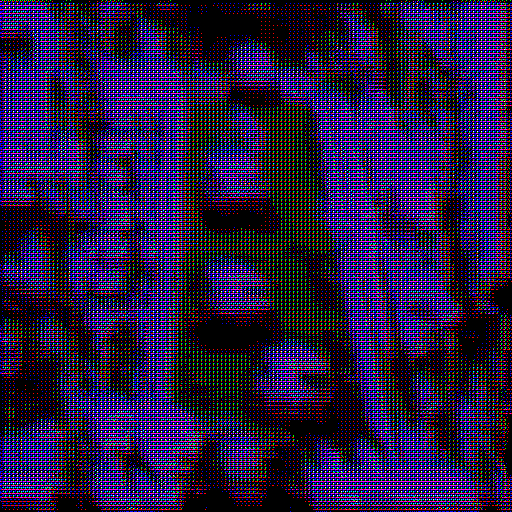

In [27]:
prediction = model.predict(content_image)
display.display( tensor_to_image( prediction))

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    prediction = model(image)
    outputs = feature_extractor(prediction)
  
    loss  = style_content_loss(outputs["style"], style_targets, outputs["content"], content_targets)
    loss += tf.image.total_variation(image) * total_variation_weight

  grad = tape.gradient(loss, model.trainable_variables )
  opt.apply_gradients(zip(grad, model.trainable_variables))
  output.assign(clip_0_1(prediction))
  train_loss(loss)

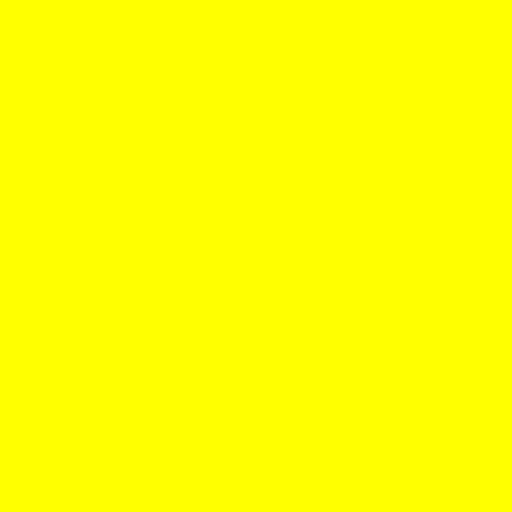

100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


In [28]:
source_path = "/content/saved_images"

if not os.path.isdir(source_path):
  os.mkdir(source_path)

for epoch in tqdm.trange(1000):
  train_step(image)

  if epoch%10==0:
    display.clear_output(wait=True)
    display.display(tensor_to_image(output))
  if epoch%100==0:
    img = tensor_to_image(output)
    img.save( os.path.join("/content/saved_images", get_time()+".jpg"))
  
    loss = train_loss.result()
    print("train loss: {}".format(loss.numpy()))
  
  train_loss.reset_states()

# Evaluate

In [0]:
prediction = model.predict(content_image)
display.display( tensor_to_image( prediction))

# Test coding cells


In [0]:
opt = tf.optimizers.Adam(learning_rate=1e-2, beta_1=0.99, epsilon=1e-1)

In [0]:
# model = tf.keras.Sequential([tf.keras.layers.Conv2D(128, 3,2,'same'),
#                         tf.keras.layers.Conv2D(64, 3,2,'same'),
#                         tf.keras.layers.Conv2D(32, 3,2,'same'),
#                         tf.keras.layers.Conv2DTranspose(32, 3,2,'same'),
#                         tf.keras.layers.Conv2DTranspose(64, 3,2,'same'),
#                         tf.keras.layers.Conv2DTranspose(128, 3,2,'same'),
#                         tf.keras.layers.Conv2DTranspose(3, 3,1,'same'),
#                         ])

In [0]:
image = tf.Variable(content_image)
output = tf.Variable(content_image)

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    prediction = model(image)
    outputs = feature_extractor(prediction)
  
    loss  = style_content_loss(outputs["style"], style_targets, outputs["content"], content_targets)
    loss += tf.image.total_variation(prediction)
    # loss = tf.image.total_variation(image) * total_variation_weight


  grad = tape.gradient(loss, model.trainable_variables )
  opt.apply_gradients(zip(grad, model.trainable_variables))
  output.assign(clip_0_1(prediction))
  train_loss(loss)

In [0]:
source_path = "/content/saved_images"

if not os.path.isdir(source_path):
  os.mkdir(source_path)

for epoch in tqdm.trange(10000):
  train_step(output)

  if epoch%100==0:
    display.clear_output(wait=True)
    display.display(tensor_to_image(output))
  # if epoch%100==0:
  #   img = tensor_to_image(output)
  #   img.save( os.path.join("/content/saved_images", get_time()+".jpg"))
  
  #   loss = train_loss.result()
  #   print("train loss: {}".format(loss.numpy()))
  
  train_loss.reset_states()

# Cleaning

In [0]:
create_video("./test.gif", source_path)

In [0]:
remove_files("/content/saved_images", 
             "/content/model.png", 
            #  "/content/test.gif"
             )